In [167]:
import pipelines_classes as our_ppl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import json
import re
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn.model_selection import cross_validate
import category_encoders as ce
import math
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.tree import export_graphviz
# from graphviz import Source
from IPython.display import SVG
from sklearn.model_selection import RandomizedSearchCV


from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [2]:
pd.options.display.max_columns = None

In [3]:
other_train = pd.read_csv('31/other_train.csv')
other_valid = pd.read_csv('31/other_valid.csv')
other_test = pd.read_csv('31/other_test.csv')

personal_train = pd.read_csv('31/personal_train.csv')
personal_valid = pd.read_csv('31/personal_valid.csv')
personal_test = pd.read_csv('31/personal_test.csv')

In [4]:
result_train = our_ppl.merge_and_deduplicate(personal_train, other_train, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [5]:
result_valid = our_ppl.merge_and_deduplicate(personal_valid, other_valid, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [6]:
result_test = our_ppl.merge_and_deduplicate(personal_test, other_test, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [7]:
other_valid.shape

(1022, 34)

In [8]:
personal_valid.shape

(972, 6)

In [9]:
result_valid.shape

(972, 38)

In [10]:
result_train.shape

(2237, 38)

In [11]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'FTI','age']

all_numeric_columns = ['FTI', 'T3', 'T4U',  'TSH', 'TT4', 'age', 'capital-gain',
                       'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']

categorical_columns = ['occupation','sex','workclass', 'tumor']

all_categorical_columns = ['marital-status','education','native-country','occupation',
                       'race','referral source','relationship','sex','sick','tumor','workclass',
                       'pregnant',	'thyroid surgery', 'I131 treatment',  'psych', 'query hypothyroid']


encoder = ce.OneHotEncoder()
model_numeric = LinearRegression()
model_categorical = RandomForestClassifier(n_estimators = 100,
                    max_depth = 12, random_state = 8)


ppl = Pipeline([
    
    ('ExtraxtMedicalInfo',our_ppl.Extraction('medical_info')),
    ('AllNumObjectstoNumeric', our_ppl.ObjectToNumeric(all_numeric_columns)),
    
    
    ('ReplaceFalseCorrect',our_ppl.StringReplacer(true_false_cols,'f','f')),
    ('ReplaceTrueCorrect',our_ppl.StringReplacer(true_false_cols,'t','t')),
    
    ('ReplaceClassNegative',our_ppl.StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',our_ppl.StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',our_ppl.StringReplacer(['class'],'decrease','decreased')),
    
    ('FindNans', our_ppl.StringReplacer(all_categorical_columns, '?', np.NaN)),
    
    # normalizacia
    ('Ln', our_ppl.LogNormalization(numeric_columns)),
    # odstranenie outlierov
    ('ReplaceExtremes',our_ppl.ReplaceOutliersWithPercentile(numeric_columns)),
    # doplnenie prazdnych hodnot modelmi
    ('ReplaceNumericNansWithModel',our_ppl.ReplaceNanWithModel(numeric_columns, LinearRegression(), numeric_columns)),
    ('ReplaceCategoricalNansWithModel', our_ppl.ReplaceCategoryNanWithModel(['occupation','sex','workclass','tumor'],
                                                               ['occupation','sex','workclass', 'tumor', 'marital-status'],
                                                                model_categorical, encoder)),
    # doplnenie prazdnych hodnot v pripade velkeho poctu kategorii, ktore predpokladame, ze z pohladu analyzy nezohravaju az taku dolezitu ulohu
    ('ReplaceWithMostFrequent', our_ppl.ReplaceMostFrequent(col_names=['native-country','FTI measured', 'relationship',
                                                               'query hypothyroid','hours-per-week']))
    
#     ("SelectColumns",our_ppl.Selector(columns = []))
    
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)
X_valid = ppl.transform(result_valid)

-- Extraction of  medical_info
-- Transform object to numeric for:  ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age', 'capital-gain', 'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']
-- Replacing: ** f ** to:  f  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** t ** to:  t  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** negativ ** to:  negative  , for:  ['class']
-- Replacing: ** increase ** to:  incr

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


pocet hodnot: 2000/2237, workclass(accuracy score): 0.749998054226
pocet hodnot: 2000/2237, tumor(accuracy score): 0.975001128132
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  360
pocet predikovanych pre  T4U :  235
pocet predikovanych pre  TSH :  232
pocet predikovanych pre  T3 :  468
pocet predikovanych pre  FTI :  235
pocet predikovanych pre  age :  1
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  139
pocet predikovanych pre  T4U :  90
pocet predikovanych pre  TSH :  85
pocet predikovanych pre

In [ ]:
X_train.head()

In [ ]:
X_valid.head()

## Manualne pravidla

Na manualnu predikciu pouzijeme ciselne atributy, najma intenzity proteinov. vykreslime scatterploty, aby sme videli, kde by sme mohli urcit manualne hranicu 

In [ ]:
sns.pairplot(X_train, vars=['TT4','T4U', 'capital-loss', 'capital-gain', 'TSH', 'T3', 'fnlwgt', 'education-num', 'FTI'], hue='class')

In [ ]:
sns.scatterplot(x = "T4U", y = 'TT4', data = X_train, hue = 'class')
plt.plot([0.22,0.22],[4.75,5.5],linewidth = 2,color = 'red')
plt.plot([0.22,0.5],[4.75,4.75],linewidth = 2,color = 'red')

Na zaklade atributov T4U a TT4 vieme urcit oblast, kde sa nachadzaju prevazne meranie z kategorie 'increased'

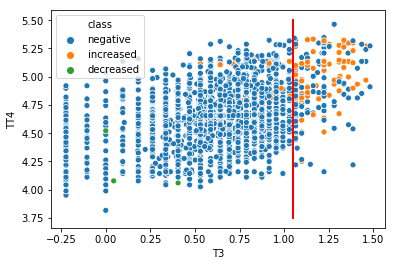

In [175]:
sns.scatterplot(x = "T3", y = 'TT4', data = X_train, hue = 'class')
plt.plot([1.05,1.05],[3.75,5.5],linewidth = 2,color = 'red')

Na zaklade atributu T3 vieme urcit hranicu, nad ktorou sa nachadzaju prevazne hodnoty 'increased'.

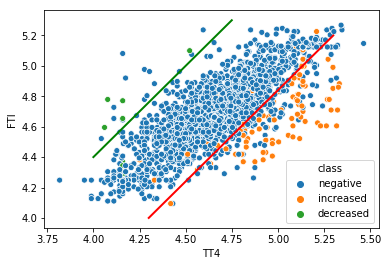

In [179]:
sns.scatterplot(x = "TT4", y = 'FTI', data = X_train, hue = 'class')
plt.plot([4.3,5.3],[4,5.2],linewidth = 2,color = 'red')
plt.plot([4,4.75],[4.4,5.3],linewidth = 2,color = 'green')

Na zaklade atributov TT4 a FTI vieme najst priblizne hranice (pre jednoduchost su to len priamky), na zaklade ktorych vieme rozdelit merania do troch kategorii

Zostavime funkciu, ktora na zaklade stanovenych hranic zaradi jednotlive merania do kategorii

In [55]:
def manual_features(df):
    predicted = []
    for index,row in df.iterrows():
        pred = 0
         
        if row['T4U'] > 0.22 and row['TT4'] > 4.75:
            pred +=1
            
        if row['T3'] > 1.05:
            pred +=1
        
        if 1.2 * row['TT4'] - 1.16 > row['FTI']:
            pred +=1
        elif 1.2 * row['TT4'] - 0.4 < row['FTI']:
            pred -=1
        
        if pred > 2:
            predicted.append('increased')
        elif pred < 0:
            predicted.append('decreased')
        else:
            predicted.append('negative')
    
    return predicted
            
    

In [183]:
pred = manual_features(X_valid)

In [184]:
accuracy_score(pred, X_valid['class'])

0.96913580246913578

In [185]:
f1_score(X_valid['class'], pred, average='macro') 

0.68134185303514372

In [186]:
f1_score(X_valid['class'], pred, average='micro') 

0.96913580246913589

In [187]:
confusion_matrix(pred, X_valid['class'])

array([[  4,   0,   7],
       [  0,  14,  11],
       [  1,  11, 924]], dtype=int64)

Vidime, ze manualny klasifikator dosiahol accuracy score nad validacnou vzorkou 96.9 percent, ale tento udaj je nie uplne smerodajny, kedze drtiva vacsina merani je z triedy 'negative' (teda keby pre kazde meranie predikujeme 'negative' dosiahli by sme uspesnost okolo 95 percent). Z confusion matrix vidime, ze sme spravne urcili 4 z piatich merani so snizenou hondnotou proteinov, ale v pripade zvysenej hladiny mame horsiu uspesnost, nasli sme len 14 z 25 pripadov. Vacsinou negativnych sme urcili spravne, male mnozstvo (oproti celkovemu mnozstvu) z nich bolo identifikovane, ako chori pacienti.

## Klasifikator s vyuzitim rozhodovacich stromov

### 1. Decision tree

Ako prve pouzijeme decision tree

##### 1.1 Priprava dat (vyber atributov a ich oneHot encoding)

In [42]:
encoder = ce.OneHotEncoder(cols = [])

columns_dt = ['age', 'sex', 'FTI',
        'T3', 'T4U','TSH', 'TT4',
         'capital-loss', 
       'education',  'fnlwgt', 'goitre', 'hours-per-week',
       'hypopituitary', 'lithium', 'marital-status',
       'native-country', 'occupation', 'on antithyroid medication',
       'query hyperthyroid', 'race', 'referral source', 'relationship', 'sick',
       'tumor', 'workclass', 'query hypothyroid','pregnant',
       'thyroid surgery', 'query on thyroxine',
       'I131 treatment', 'on thyroxine','psych','class']

ctg_to_encode = ['sex','education','goitre','hypopituitary','lithium','marital-status',
                 'native-country','occupation','on antithyroid medication','query hyperthyroid',
                 'race', 'referral source', 'relationship', 'sick',
                 'tumor', 'workclass', 'query hypothyroid','pregnant',
                 'thyroid surgery', 'query on thyroxine',
                 'I131 treatment', 'on thyroxine','psych'
                ]
ppl_dt = Pipeline([
    ("SelectColumns",our_ppl.Selector(columns = columns_dt)),
     ("EncodeCatego",ce.OneHotEncoder(cols = ctg_to_encode))    
])


model =ppl_dt.fit(X_train)
X_train_dt = ppl_dt.transform(X_train)
X_valid_dt = ppl_dt.transform(X_valid)

In [ ]:
X_train_dt.head()

##### 1.2 Pozorovanie modelov DecisionTree s rozdielnymi hlbkami 

In [224]:
def train_dt(max_depth = 10, X_train = [],X_test=[],y_train=[],y_test=[]):
    results = []
    for i in range(2, max_depth):  
        row = {'model_complexity': i}

        clf_d = DecisionTreeClassifier(max_depth = i)

        pred = clf_d.fit(X_train,y_train).predict(X_train)
        row['train'] = accuracy_score(y_train, pred)

        pred = clf_d.predict(X_test)
        row['test'] = f1_score(y_test, pred, average='micro')
        row['score_f'] = f1_score(y_test, pred, average='macro')

        results.append(row)
        
    return results

In [199]:
results = train_dt(50,
                   X_train_dt[X_train_dt.columns.difference(['class'])],
                   X_valid_dt[X_valid_dt.columns.difference(['class'])],
                   X_train_dt['class'],
                   X_valid_dt['class']
                  )
results

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[{'model_complexity': 2,
  'train': 0.97049620026821637,
  'test': 0.97325102880658432,
  'score_f': 0.51922398589065255},
 {'model_complexity': 3,
  'train': 0.975860527492177,
  'test': 0.97530864197530864,
  'score_f': 0.53318216175359023},
 {'model_complexity': 4,
  'train': 0.97854269110415737,
  'test': 0.98045267489711929,
  'score_f': 0.56609524648921794},
 {'model_complexity': 5,
  'train': 0.983907018328118,
  'test': 0.96810699588477367,
  'score_f': 0.62658765432098762},
 {'model_complexity': 6,
  'train': 0.99061242735806887,
  'test': 0.9711934156378601,
  'score_f': 0.54655061250805936},
 {'model_complexity': 7,
  'train': 0.99508270004470267,
  'test': 0.97325102880658432,
  'score_f': 0.65778323331514821},
 {'model_complexity': 8,
  'train': 0.99687080911935633,
  'test': 0.97325102880658432,
  'score_f': 0.66205182818601349},
 {'model_complexity': 9,
  'train': 0.99776486365668304,
  'test': 0.97222222222222221,
  'score_f': 0.60905178899220613},
 {'model_complexity':

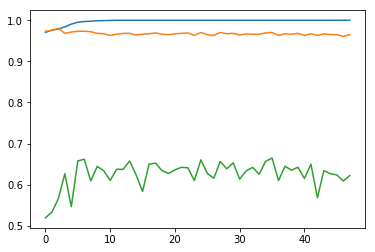

In [200]:

plt.plot([row['train'] for row in results])
plt.plot([row['test'] for row in results])
plt.plot([row['score_f'] for row in results])

Pri hlbke 3 az 4 je hranica, za ktorou nastava pretrenovanie, model dava lepsie vysledky na trenovacich datach, ale postupne horsie na testovacich.

##### 1.3 Vizualizacia rozhodovacích stromov

Pomocou grafu vizualizujeme rozhodovanie jedneho z decision tree modelov, ktory dosahoval dobre vysledky predikcie. 

In [171]:
def evaluate(prediciton,correct_vals):
    print('accuracy: ',accuracy_score(correct_vals, prediciton))
#     print('recall: ',recall_score(correct_vals, prediciton, average = "weighted"))
#     print('precision: ',precision_score(correct_vals, prediciton, average = "weighted"))
#     print('f1_micro: ',f1_score( prediciton, correct_vals, average = 'micro'))
#     print('f1_macro: ',f1_score(prediciton,correct_vals, average = 'macro'))
#     print('f1_weighted: ',f1_score(prediciton,correct_vals,average='weighted'))
    print(classification_report(prediciton,correct_vals))
    
    

Pri vizualizacii sme zvolili strom s hlbkov 4, ktorá sa bude jednoduchšie vizualizovať a zároveň ma nejlepšei výsledky

In [172]:
clf_d = DecisionTreeClassifier(max_depth = 4)    
pred = clf_d.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class']).predict(X_valid_dt[X_valid_dt.columns.difference(['class'])])
evaluate(pred,X_valid_dt['class'])


accuracy:  0.980452674897
              precision    recall  f1-score   support

   decreased       0.00      0.00      0.00         0
   increased       0.68      0.74      0.71        23
    negative       0.99      0.99      0.99       949

   micro avg       0.98      0.98      0.98       972
   macro avg       0.56      0.58      0.57       972
weighted avg       0.99      0.98      0.98       972



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


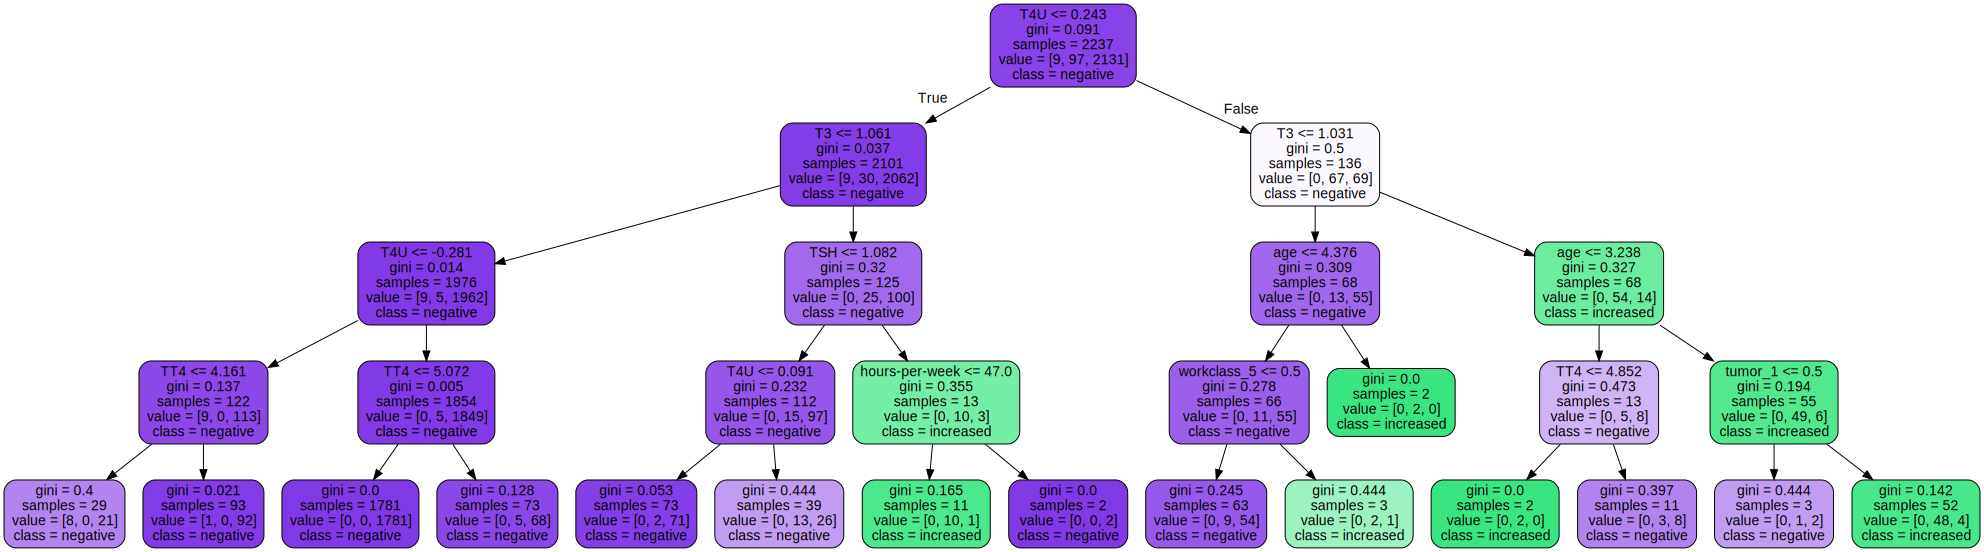

In [203]:
graph = Source(export_graphviz(clf_d, 
                               out_file=None,
                               feature_names=X_train_dt.columns.difference(['class']),
                               class_names=['decreased','increased','negative'],
                               filled = True,
                              rounded = True
                              ))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:50% !important;height:20% !important;}</style>"
HTML(style)

Z vizualizácie mozeme citat kolko pripadov z jednotlivych kategorií bolo zaklasifikovaných pomocou jednotlivých pravidiel v strome. 
Napríklad kategoria **increased** sa najuspešnejšie podarila klasifikovat pomocou atributov **T4U, T3, age a tumor**.
Kategoria **decreased** bola klasifikovaná najuspešnejšie v jednej vetve **T4U, T3, T4U, TT4**
Pri klasifikovanie kategorie **negativ** asi najviac pomohol atribut **T4U**

Ako sa ukázalo, rozhodovací strom sa naučil pravidla na atribútoch, ktore sme používali v manualnej predikcii. To naznačuje, že naše úvahy boli správne. 


##### 1.4. Vyber atributov 

Pozrieme sa na strom bez obmedzeni hlbky a na uzitocnost jednotlivych atributov, ako velmi su napomocne pri predikcii

In [28]:
clf_d = DecisionTreeClassifier()

clf_d = clf_d.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class'])

In [29]:
X_train_dt[X_train_dt.columns.difference(['class'])].shape

(2237, 160)

In [30]:
clf_d.feature_importances_

array([ 0.04430285,  0.        ,  0.        ,  0.        ,  0.1661409 ,
        0.34439269,  0.07666508,  0.05832728,  0.06632338,  0.00404722,
        0.        ,  0.        ,  0.        ,  0.00887859,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.03866306,  0.        ,
        0.00736473,  0.        ,  0.02896949,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01361211,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00473122,  0.00857058,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00785973,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00

Vidime, ze vela atributov nezavazilo pri rozhodovani vobec, tie mozeme vynechat

In [31]:
new_cols = [X_train_dt.columns.difference(['class'])[x] for x in range(0,len(X_train_dt.columns.difference(['class']))) if clf_d.feature_importances_[x] != 0]

Overme aku uspesnost bude dosahovat strom len na vybranych atributoch 

In [204]:
results = train_dt(50,
                   X_train_dt[new_cols],
                   X_valid_dt[new_cols],
                   X_train_dt['class'],
                   X_valid_dt['class']
                  )

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


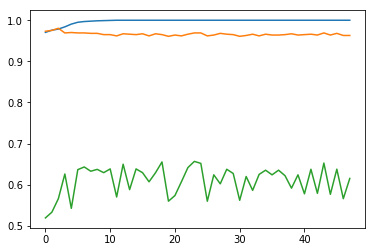

In [205]:
plt.plot([row['train'] for row in results])
plt.plot([row['test'] for row in results])
plt.plot([row['score_f'] for row in results])

Môžeme vidieť, že rozhodovaci strom na vybranej sade atributov dosahuje rovnake vysledky ako pri velkom mnozstve atributov.  

##### 1.5 Vyber hyperparametrov

Nastavime, ktore parametre chceme vyladit a z akeho rozsahu.

In [216]:
ind_params = {'random_state': 0}

random_params = {
    'max_depth': stats.randint(1,30),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best','random'],
    'min_samples_leaf': stats.randint(1,5)
}

clf = DecisionTreeClassifier

Parametre ktore budeme optimalizovat:
* maximalna hlbka stromu od **1** po **30**
* funkcia urcujuca kvalitu vetvenia **gini** alebo **entropy**
* pravidlo vyberu vetvenia **best** alebo **random**
* minimalny pocet pozorovani ktore mozu tvorit jeden uzol od **1** do **5**

Pouzijeme RandomSearch

In [217]:
random_optimization = RandomizedSearchCV(clf(**ind_params), param_distributions = random_params, 
                               n_iter = 1000, scoring = 'f1_macro', cv = 10, verbose=True,
                                         random_state=42, n_jobs = -1)

In [218]:
%%time
random_optimization.fit(X_train_dt[new_cols], X_train_dt['class'])

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 7324 tasks      | elapsed:   41.9s


Wall time: 57.2 s


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   56.7s finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000198DB1C6BA8>, 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000198DA42D4A8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=True)

In [219]:
random_optimization.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [220]:
np.sort(random_optimization.cv_results_['mean_test_score'])[-10:]

array([ 0.70144385,  0.70144385,  0.70144385,  0.70144385,  0.70144385,
        0.70144385,  0.70144385,  0.70144385,  0.70144385,  0.70781249])

Vidime, ze niekolko najlepsich nastaveni dalo velmi podobne vysledky

In [221]:
indexes = np.argsort(random_optimization.cv_results_['mean_test_score'])[-10:]

In [222]:
for x in indexes:
    print(random_optimization.cv_results_['params'][x])

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 27, 'min_samples_leaf': 2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'splitter': 'best'}


Pre 10 najlepsich nastaveni (na zaklade priemerneho skore z cross validacie) mame velku premenlivost nastaveni, napriklad maximalna hlbka od 9 az do 28.

##### 1.6 Vizualizacia vysledneho rozhodovacieho stromu

In [229]:
clf_d_b = DecisionTreeClassifier(max_depth = 9, criterion = 'entropy', min_samples_leaf = 2, splitter = 'best')  

pred = clf_d_b.fit(X_train_dt[new_cols],X_train_dt['class']).predict(X_valid_dt[new_cols])
evaluate(pred,X_valid_dt['class'])

accuracy:  0.955761316872
f1_micro:  0.955761316872
f1_macro:  0.56545497076
recall:  0.955761316872


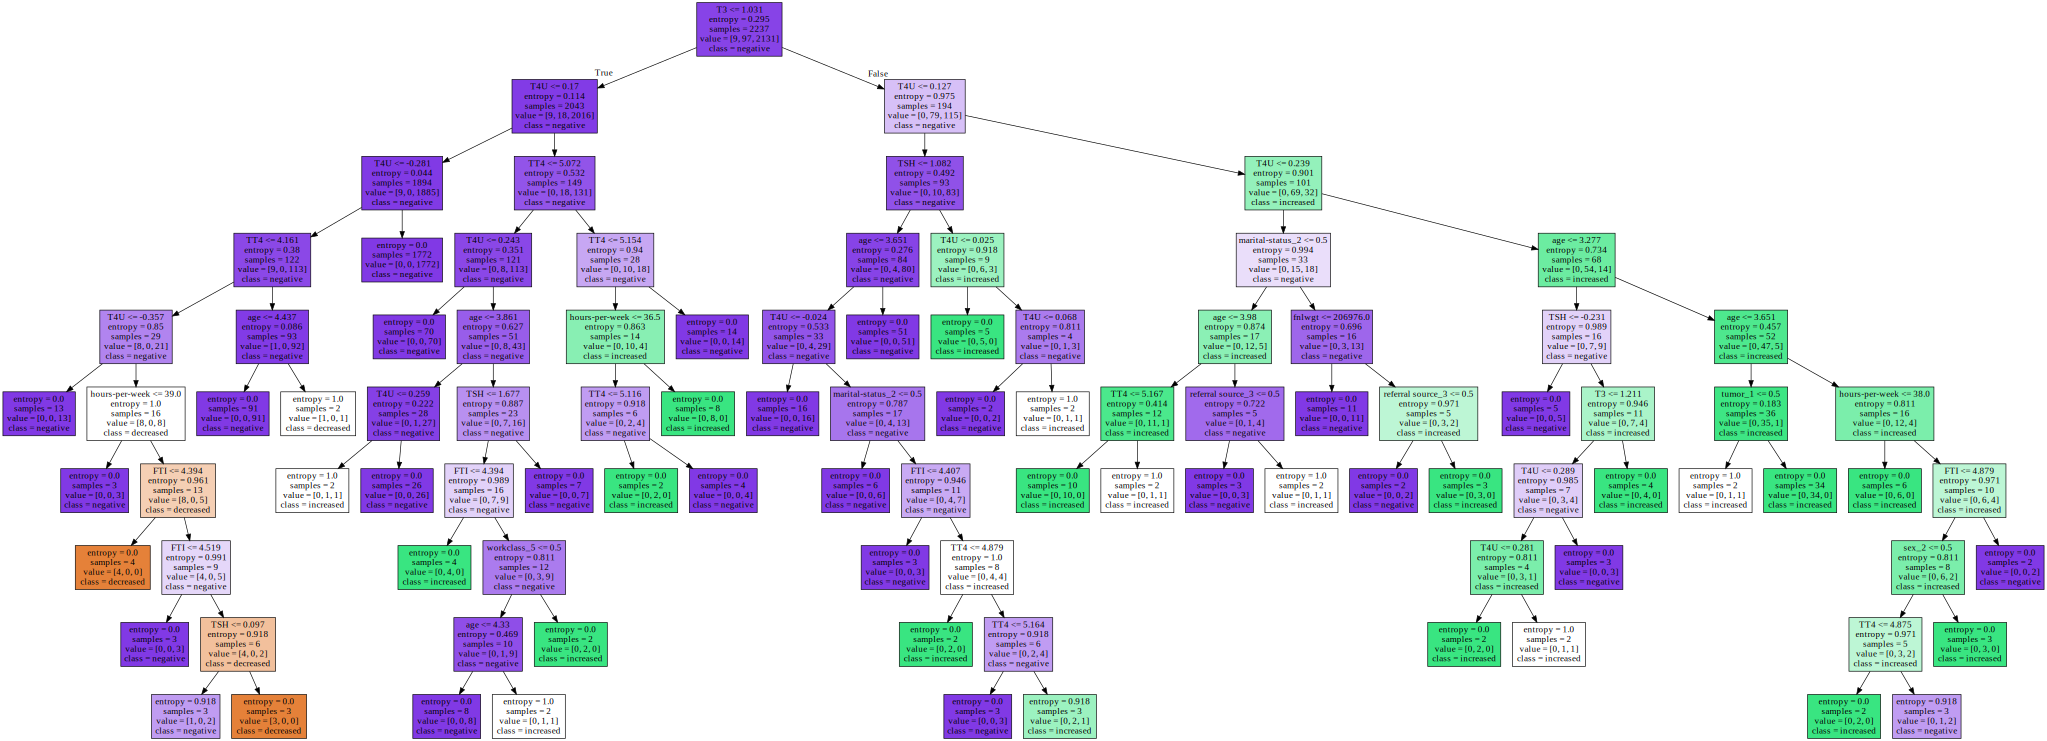

In [235]:
graph = Source(export_graphviz(clf_d_b, 
                               out_file=None,
                               feature_names=new_cols,
                               class_names=['decreased','increased','negative'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)

Ukazalo sa ze pri trenovani krizova validacia vykazovala dobre vysledky na konfiguracii hyperparametrov, ktore sme definovali pomocou random serach, ale pri teste na validacnych datach sa ukazalo ze vysledky su horsie a zaroven su horsie ako nas prvy jedniduchy model s maximalnou hlbkou 4. Vysledok moze byt ovplyvneny tym ze model je pretrenovany alebo random search nemusi najst najlepsie riesenie, pretoze nahodne prehladava priestor konfiguracii.

### Pozorovanie dalsich modelov

##### Random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
clf_rf = RandomForestClassifier(n_estimators = 500, max_depth = 7, random_state=8)

In [45]:
clf_rf.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [39]:
pred = clf_rf.predict(X_valid_dt[X_valid_dt.columns.difference(['class'])])
evaluate(pred,X_valid_dt['class'])


#### Logistic regression

In [263]:
from sklearn.linear_model import LogisticRegression

In [264]:
clf_lr = LogisticRegression()

In [265]:
clf_lr.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class'])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [268]:
pred = clf_lr.predict(X_valid_dt[X_valid_dt.columns.difference(['class'])])
evaluate( pred, X_valid_dt['class'])

accuracy:  0.969135802469
f1_micro:  0.969135802469
f1_macro:  0.328108672936
recall:  0.969135802469


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Predikcia na testovacej sade

#### Predspracovanie dat

In [278]:
result_test.head(1)


,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI,FTI measured,I131 treatment,T3,T3 measured,T4U,T4U measured,TBG,TBG measured,TSH,TSH measured,TT4,TT4 measured,Unnamed: 0_y,capital-gain,capital-loss,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,occupation,on antithyroid medication,on thyroxine,personal_info,pregnant,psych,query hyperthyroid,query hypothyroid,query on thyroxine,referral source,sick,thyroid surgery,tumor,workclass
0,0,Alfredo Abels,"39033 Peterson Ways Suite 476\nJustinmouth, AL...",13,M,2005-05-22,100,t,f,2.8,t,1.1,t,?,f,2.7,t,110.0,t,526,0.0,0.0,10.0,176544.0,f,48.0,f,f,Other-service,f,f,White|United-States\nSome-college -- Never-mar...,f,f,f,f,f,other,f,f,f,Private


Stlpec personal info je novy oproti povodnemu trenovaciemu datasetu a obsahuje stlpce **'race', 'native-country','education','marital-status','relationship'** ktore potrebujeme extrahovat. Taktiež jednym z rozdielov oproti pôvodnemu datasetu je, že neobsahuje stlpec **medical_info** a vsetky jeho polozky sa uz nachadzaju v samostatnych stlpcoch. Na extrakciu personal-info potrebujeme novu class v nasej pipeline, ktora rozdeli polozku na viacero stlpcov. (doteraz sme pracovali len s medical_info, ktora bola vo formate json a nie retazca).

Extrahovanie medical_info a personal_info z jednotlivych datasetov vykoname zvlast na datasetoch, este pred spolocnym predspracovanim

In [92]:
personal_extraction = our_ppl.ExtractionString(column = 'personal_info')

In [93]:
medical_extraction = our_ppl.Extraction('medical_info')

In [94]:
personal_extraction.fit(result_test)
medical_extraction.fit(result_train)

-- Extraction of  personal_info
-- Extraction of  medical_info


In [95]:
result_tt  =  personal_extraction.transform(result_test)
result_tr  =  medical_extraction.transform(result_train) 

In [100]:
columns_dt.remove('class')

Teraz uz mozeme dalej predspracovat data rovnakym sposobom, ako predtym

In [102]:
encoder = ce.OneHotEncoder()

ppl_fin = Pipeline([
    
    ('AllNumObjectstoNumeric', our_ppl.ObjectToNumeric(all_numeric_columns)),
    ('StringCorrection',our_ppl.StringCorrection(['workclass'])),
    
    ('ReplaceFalseCorrect',our_ppl.StringReplacer(true_false_cols,'f','f')),
    ('ReplaceTrueCorrect',our_ppl.StringReplacer(true_false_cols,'t','t')),
    ('ReplaceWS',our_ppl.StringReplacer(['workclass'],' Private','Private')),
  
    ('FindNans', our_ppl.StringReplacer(all_categorical_columns, '?', np.NaN)),
    
    # normalizacia
    ('Ln', our_ppl.LogNormalization(numeric_columns)),
    # odstranenie outlierov
    ('ReplaceExtremes',our_ppl.ReplaceOutliersWithPercentile(numeric_columns)),
    # doplnenie prazdnych hodnot modelmi
    ('ReplaceNumericNansWithModel',our_ppl.ReplaceNanWithModel(numeric_columns, LinearRegression(), numeric_columns)),
    ('ReplaceCategoricalNansWithModel', our_ppl.ReplaceCategoryNanWithModel(['occupation','sex','workclass','tumor'],
                                                               ['occupation','sex','workclass', 'tumor', 'marital-status'],
                                                                model_categorical, encoder)),
    # doplnenie prazdnych hodnot v pripade velkeho poctu kategorii, ktore predpokladame, ze z pohladu analyzy nezohravaju az taku dolezitu ulohu
    ('ReplaceWithMostFrequent', our_ppl.ReplaceMostFrequent(col_names=['native-country','FTI measured', 'relationship',
                                                               'query hypothyroid','hours-per-week'])),
    ("SelectColumns",our_ppl.Selector(columns = columns_dt)),
    ("EncodeCatego",ce.OneHotEncoder(cols = ctg_to_encode))
    
])


model =ppl_fin.fit(result_tr)
X_train = ppl_fin.transform(result_tr)
X_test = ppl_fin.transform(result_tt)

-- Transform object to numeric for:  ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age', 'capital-gain', 'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']
-- Correction of  ['workclass']
-- Replacing: ** f ** to:  f  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** t ** to:  t  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: **  Private ** to:  Private  , for:  ['workclass']
-- Replacing: ** ? ** to:  nan  ,

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


pocet hodnot: 2000/2237, workclass(accuracy score): 0.749998054226
pocet hodnot: 2000/2237, tumor(accuracy score): 0.975001128132
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  360
pocet predikovanych pre  T4U :  235
pocet predikovanych pre  TSH :  232
pocet predikovanych pre  T3 :  468
pocet predikovanych pre  FTI :  235
pocet predikovanych pre  age :  1
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  36
pocet predikovanych pre  T4U :  62
pocet predikovanych pre  TSH :  52
pocet predikovanych pre 

Napiseme funkciu na exportovanie vysledkov

In [122]:
def extract_results(pred, filename):
    words = {'negative': 'negative','increased': 'increased binding protein','decreased':'decreased binding protein'}
    answer = list(map(lambda x: kk[x]  ,pred))  
    final = pd.DataFrame(pred,columns = ['Predicted'])
    final.index.name = "Id"
    final.to_csv(filename)
    

##### Manualna predikcia

Ako prve skusime nasu manualnu predikciu

In [177]:
pred = manual_features(X_test)

In [178]:
evaluate(manual_features(X_valid_dt[X_test.columns]),X_valid_dt['class'])

accuracy:  0.969135802469
              precision    recall  f1-score   support

   decreased       0.80      0.36      0.50        11
   increased       0.56      0.56      0.56        25
    negative       0.98      0.99      0.98       936

   micro avg       0.97      0.97      0.97       972
   macro avg       0.78      0.64      0.68       972
weighted avg       0.97      0.97      0.97       972



In [114]:
extract_results(pred, 'manual.csv')

Nasa manualna predikcia dosiahla mean f-score na kaggle **0.94674**.

##### Decision tree

Skusime predikciu pomocou decision tree s konfiguraciou, ktora sa javila ako vhodna na trenovacich datach

In [135]:
clf = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy', min_samples_leaf = 2, splitter = 'best')

In [136]:
clf.fit(X_train, X_train_dt['class'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [137]:
pred = clf.predict(X_test)

In [138]:
evaluate(clf.predict(X_valid_dt[X_test.columns]),X_valid_dt['class'])

accuracy:  0.968106995885
f1_micro:  0.968106995885
f1_macro:  0.506417064967
f1_weighted:  0.969254500414


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
extract_results(pred, 'dt1.csv')

Tento model dosiahol na kaggle mean f-score **0.92307** 

##### Random forest

In [156]:
clf_rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state=8)

In [157]:
clf_rf.fit(X_train, X_train_dt['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [158]:
pred = clf_rf.predict(X_test)

In [176]:
evaluate(clf_rf.predict(X_valid_dt[X_test.columns]),X_valid_dt['class'])

accuracy:  0.973251028807
              precision    recall  f1-score   support

   decreased       0.00      0.00      0.00         0
   increased       0.32      0.67      0.43        12
    negative       1.00      0.98      0.99       960

   micro avg       0.97      0.97      0.97       972
   macro avg       0.44      0.55      0.47       972
weighted avg       0.99      0.97      0.98       972



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [174]:
extract_results(pred, 'rf1.csv')

In [175]:
np.unique(pred)

array(['increased', 'negative'], dtype=object)